Shape of the dataset: (128975, 2)

First 10 rows of the dataset:
        Date  Amount
0 2022-04-30  647.62
1 2022-04-30  406.00
2 2022-04-30  329.00
3 2022-04-30  753.33
4 2022-04-30  574.00
5 2022-04-30  824.00
6 2022-04-30  653.00
7 2022-04-30  399.00
8 2022-04-30     NaN
9 2022-04-30  363.00

Weekly aggregated data (first 10 weeks):
Date
2022-04-03    2892027.36
2022-04-10    6695415.95
2022-04-17    6902700.42
2022-04-24    7063406.00
2022-05-01    6466799.96
2022-05-08    7190464.94
2022-05-15    5367831.55
2022-05-22    5283885.33
2022-05-29    5583804.55
2022-06-05    6172395.21
Freq: W-SUN, Name: Amount, dtype: float64


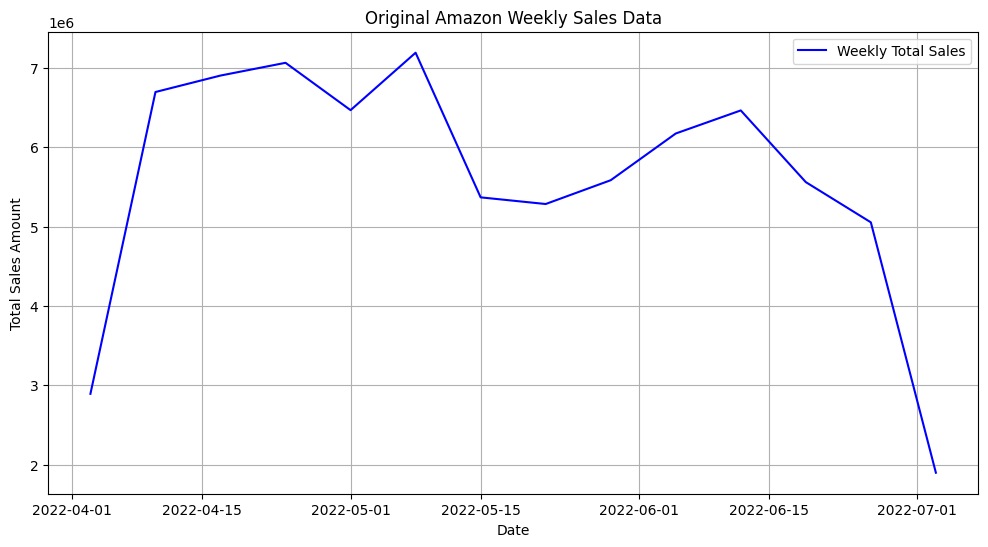


First 10 values of rolling mean (window=5):
Date
2022-04-03            NaN
2022-04-10            NaN
2022-04-17            NaN
2022-04-24            NaN
2022-05-01    6004069.938
2022-05-08    6863757.454
2022-05-15    6598240.574
2022-05-22    6274477.556
2022-05-29    5978557.266
2022-06-05    5919676.316
Freq: W-SUN, Name: Amount, dtype: float64

First 20 values of rolling mean (window=10):
Date
2022-04-03            NaN
2022-04-10            NaN
2022-04-17            NaN
2022-04-24            NaN
2022-05-01            NaN
2022-05-08            NaN
2022-05-15            NaN
2022-05-22            NaN
2022-05-29            NaN
2022-06-05    5961873.127
2022-06-12    6319003.258
2022-06-19    6205442.000
2022-06-26    6020479.361
2022-07-03    5503912.857
Freq: W-SUN, Name: Amount, dtype: float64


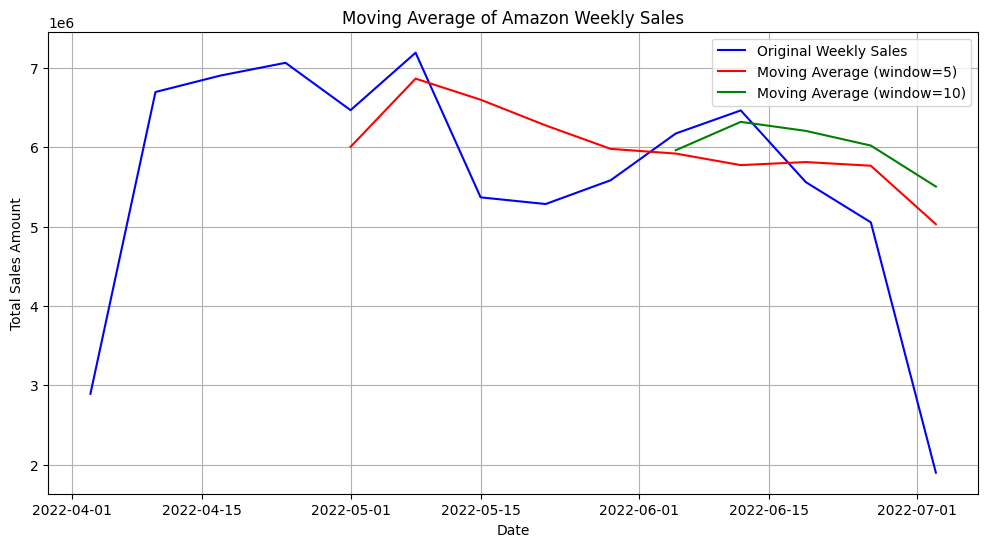

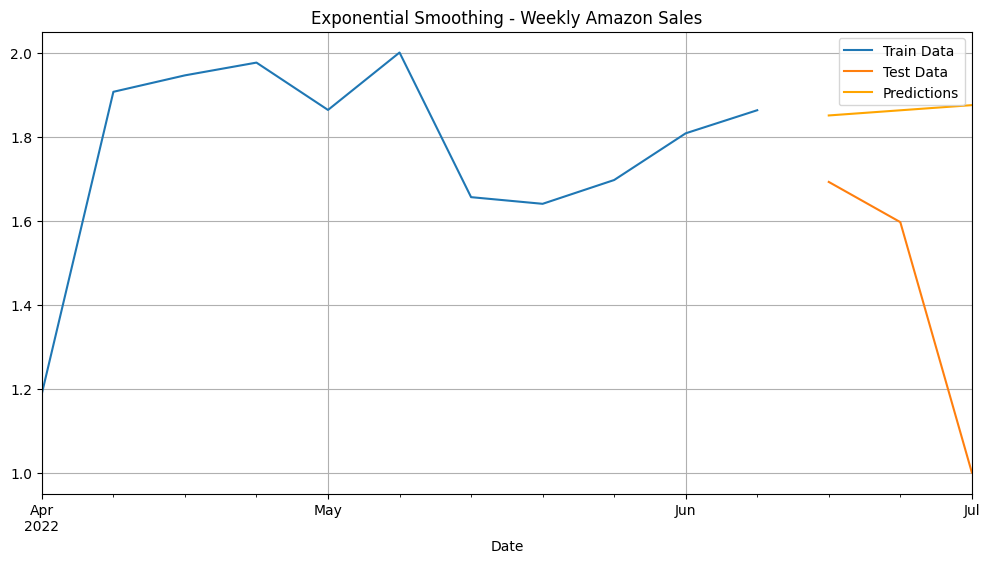


Mean Squared Error (MSE): 0.28704
Data Variance: 0.29122
Data Mean: 1.7021


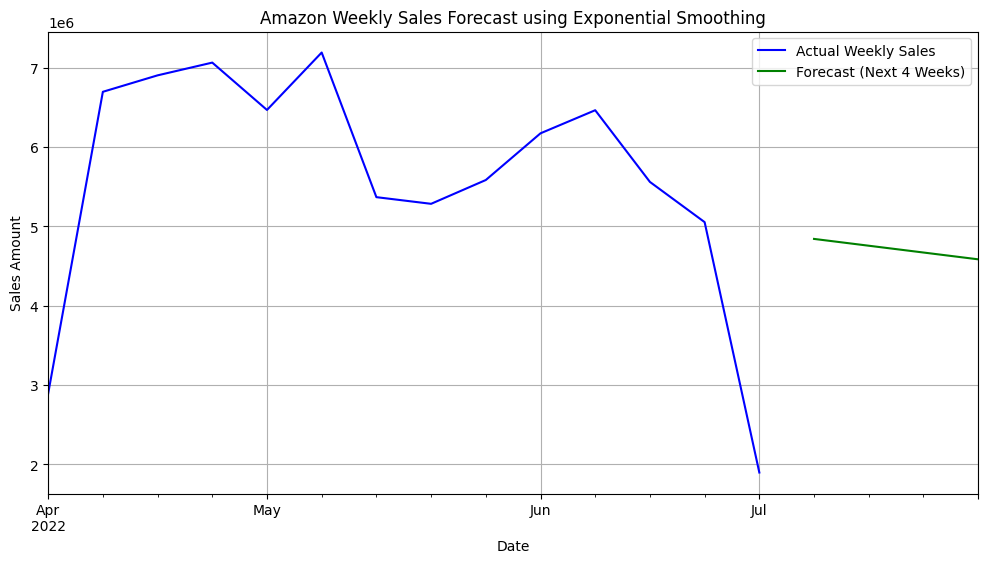

In [6]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')

# ==========================
# STEP 1: READ THE DATASET
# ==========================
data = pd.read_csv("Amazon Sale Report.csv")

# Convert 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Keep only Date and Amount columns
sales_data = data[['Date', 'Amount']]

# Display shape and first 10 rows
print("Shape of the dataset:", sales_data.shape)
print("\nFirst 10 rows of the dataset:")
print(sales_data.head(10))

# ============================================
# STEP 2: AGGREGATE TO WEEKLY SALES (if daily)
# ============================================
sales_data.set_index('Date', inplace=True)
weekly_data = sales_data['Amount'].resample('W').sum()

# Display sample weekly data
print("\nWeekly aggregated data (first 10 weeks):")
print(weekly_data.head(10))

# =================================
# STEP 3: PLOT ORIGINAL WEEKLY DATA
# =================================
plt.figure(figsize=(12, 6))
plt.plot(weekly_data, label='Weekly Total Sales', color='blue')
plt.title('Original Amazon Weekly Sales Data')
plt.xlabel('Date')
plt.ylabel('Total Sales Amount')
plt.legend()
plt.grid()
plt.show()

# ===============================
# STEP 4: MOVING AVERAGE (5 & 10)
# ===============================
rolling_mean_5 = weekly_data.rolling(window=5).mean()
rolling_mean_10 = weekly_data.rolling(window=10).mean()

print("\nFirst 10 values of rolling mean (window=5):")
print(rolling_mean_5.head(10))
print("\nFirst 20 values of rolling mean (window=10):")
print(rolling_mean_10.head(20))

# Plot moving averages
plt.figure(figsize=(12, 6))
plt.plot(weekly_data, label='Original Weekly Sales', color='blue')
plt.plot(rolling_mean_5, label='Moving Average (window=5)', color='red')
plt.plot(rolling_mean_10, label='Moving Average (window=10)', color='green')
plt.title('Moving Average of Amazon Weekly Sales')
plt.xlabel('Date')
plt.ylabel('Total Sales Amount')
plt.legend()
plt.grid()
plt.show()

# ====================================================
# STEP 5: DATA TRANSFORMATION FOR EXPONENTIAL MODEL
# ====================================================
# Scale data for smoother model training
scaler = MinMaxScaler()
scaled_data = pd.Series(
    scaler.fit_transform(weekly_data.values.reshape(-1, 1)).flatten(),
    index=weekly_data.index
)

# Handle non-positive values
scaled_data = scaled_data + 1

# Split into train and test sets (80/20)
x = int(len(scaled_data) * 0.8)
train_data = scaled_data[:x]
test_data = scaled_data[x:]

# ==========================================
# STEP 6: EXPONENTIAL SMOOTHING (Holt-Winters)
# ==========================================
model_add = ExponentialSmoothing(train_data, trend='add', seasonal=None).fit()
test_predictions = model_add.forecast(steps=len(test_data))

# Plot train, test, and prediction
ax = train_data.plot(figsize=(12, 6), label='Train Data')
test_data.plot(ax=ax, label='Test Data')
test_predictions.plot(ax=ax, label='Predictions', color='orange')
ax.legend()
ax.set_title('Exponential Smoothing - Weekly Amazon Sales')
plt.grid()
plt.show()

# Evaluate model
mse = mean_squared_error(test_data, test_predictions)
print("\nMean Squared Error (MSE):", round(mse, 5))
print("Data Variance:", round(np.sqrt(scaled_data.var()), 5))
print("Data Mean:", round(scaled_data.mean(), 5))

# ==========================================
# STEP 7: FORECAST FUTURE (NEXT 4 WEEKS)
# ==========================================
model_final = ExponentialSmoothing(weekly_data, trend='add', seasonal=None).fit()
forecast = model_final.forecast(steps=4)  # Next 4 weeks

# Plot forecast
ax = weekly_data.plot(figsize=(12, 6), label='Actual Weekly Sales', color='blue')
forecast.plot(ax=ax, label='Forecast (Next 4 Weeks)', color='green')
ax.set_xlabel('Date')
ax.set_ylabel('Sales Amount')
ax.set_title('Amazon Weekly Sales Forecast using Exponential Smoothing')
ax.legend()
plt.grid()
plt.show()
